#Assignment 2
The purpose of this assignment is to compute the sentiment of text information. Especifically in our problem, tweets posted in 2019 Canadian elections - and answer the research question: “What can public opinion on Twitter tell us about the Canadian political landscape in 2019?” The goal is to essentially use sentiment analysis on Twitter data to get insight into the 2019 Canadian elections.



In [0]:
#----------------------------------------------
# Import Libraries
#----------------------------------------------

import pandas 
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, r2_score

## Part 0 : Loading data
First of all, we load the data and take a glance on it. To start with, we first try loading the generic tweets dataset. 

In [0]:
genericData = pandas.read_csv('Sentiment.csv')

In [0]:
genericData.head()

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


## Part 1 : Data Cleaning 

### 1.1: Cleaning the generic tweets
There are too much extra characters and noise with the raw tweets as provided. So, we will now remove all extra characters, usernames, URLS and lemmatize the words as follows:
- All html tags and attributes (i.e., /<[^>]+>/) are removed.
- Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
- All URLs are removed.
- All characters in the text are set to lowercase letters.
- All stop words are removed. 

In [0]:
genericData.isna().sum()

sentiment     0
text         14
dtype: int64

At this point, there are 14 tweets that are empty and seems to be useless in our analysis. So, to prevent any possible problem, we first dop these rows.

In [0]:
genericData.dropna(inplace=True)
genericData.isna().sum()

sentiment    0
text         0
dtype: int64

Having the null rows handled, we start cleaning the raw tweets.

In [0]:
#----------------------------------------------
# Removing stopwords
#----------------------------------------------

nltk.download('stopwords')
stop = stopwords.words("english")
genericData['text']=genericData['text'].apply(lambda x:' '.join([word for word in x.split()if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#----------------------------------------------
# Lemmatizing the words
#----------------------------------------------

nltk.download('wordnet')
lemmatize = WordNetLemmatizer()
genericData['text'] = genericData['text'].apply(lambda x: ' '.join([lemmatize.lemmatize(word,'v')for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
def remove_user(input_txt,pattern):
    r = re.findall(pattern, input_txt)
    for i in r: 
        input_txt = re.sub(i,'',input_txt)
        
    return input_txt

In [0]:
#----------------------------------------------
# Cleaning html, tags, URLs, and setting all in lowercase
#----------------------------------------------

genericData['text']= np.vectorize(remove_user)(genericData['text'], "@[\w]*")
genericData['text'] = genericData['text'].str.replace("[^a-zA-Z#]", " ")
genericData['text'] = genericData['text'].str.lower()
genericData['text'] = genericData['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
genericData['text'] = genericData['text'].str.replace(r"http\S+", "")

Here we assign binary values representing the sentimnet of tweets to the values for 'Positive' and 'Negative' and 'Zero' for Neutral sentiments.

In [0]:
genericData['sentiment'] = genericData['sentiment'].str.replace("Positive", "1")
genericData['sentiment'] = genericData['sentiment'].str.replace("Negative", "-1")
genericData['sentiment'] = genericData['sentiment'].str.replace("Neutral", "0")

In [0]:
genericData.head()

,sentiment,text
0,1,they take poll number skyrocketed voters matte...
1,-1,damn jealous wanna watch fight love knows
2,1,listen beatles they great
3,1,could please shout anything huge wait
4,1,spot message tony reply


### 1.2: Cleaning the Canadian Election tweets


 We will now remove all extra characters, usernames, URLS and lemmatize the words in Canadian Election tweets by going through the same process.

In [0]:
elecData = pandas.read_csv('Canadian_elections_2019.csv')
elecData.head()

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [0]:
elecData.isna().sum()

sentiment             0
negative_reason    1126
text                  0
dtype: int64

At this point, we have to Null tweets text. Therefore, we continue without dropping any row.

In [0]:
#----------------------------------------------
# Removing stopwords
#----------------------------------------------

nltk.download('stopwords')
stop = stopwords.words("english")
elecData['text']=elecData['text'].apply(lambda x:' '.join([word for word in x.split()if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#----------------------------------------------
# Lemmatizing the words
#----------------------------------------------

nltk.download('wordnet')
lemmatize = WordNetLemmatizer()
elecData['text'] = elecData['text'].apply(lambda x: ' '.join([lemmatize.lemmatize(word,'v')for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
def remove_user(input_txt,pattern):
    r = re.findall(pattern, input_txt)
    for i in r: 
        input_txt = re.sub(i,'',input_txt)
        
    return input_txt

In [0]:
#----------------------------------------------
# Cleaning html, tags, URLs, and setting all in lowercase
#----------------------------------------------

elecData['text']= np.vectorize(remove_user)(elecData['text'], "@[\w]*")
elecData['text'] = elecData['text'].str.replace("[^a-zA-Z#]", " ")
elecData['text'] = elecData['text'].str.lower()
elecData['text'] = elecData['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
elecData['text'] = elecData['text'].str.replace(r"http\S+", "")

Here we assign binary values to the values for 'Positive' and 'Negative' and 'Neutral' tweets.

In [0]:
elecData['sentiment'] = elecData['sentiment'].str.replace("Positive", "1")
elecData['sentiment'] = elecData['sentiment'].str.replace("Negative", "-1")
elecData['sentiment'] = elecData['sentiment'].str.replace("Neutral", "0")

In [0]:
elecData.head()

,sentiment,negative_reason,text
0,-1,Women Reproductive right and Racism,instead suggestion agree #canadian #women trus...
1,1,NaN,#allwomanspacewalk real n#etobicokenorth #city...
2,-1,Economy,#brantford cost billion next years justin #elx...
3,1,NaN,#canada #canadaelection #canadavotes n#elxn nc...
4,-1,Economy,#canada #taxpayers sick tire hard earn donate ...


## Part 2 : Exploratory analysis

At this part we first develop our general understanig on the generic and Election tweets sentiments by a simple data visualization. Next, we design a simple procedure that determines the political party (Liberal, Conservative, NDP, None) of a given tweet and apply this procedure to all the tweets in the 2019 Canadian elections dataset.


### 2.1: Data visualization

First we visulize the sentiment of all tweets in generic tweets dataset. Note that 1,0,-1 are representing 'Positive', 'Neutral', and 'Negative' respectively.


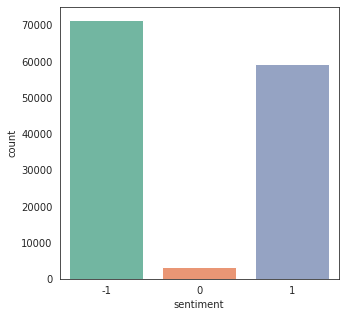

In [0]:
import seaborn as sns
% matplotlib inline
sns.set_style("white")

figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5, 5)
ax = sns.countplot(data=genericData ,x="sentiment", palette = 'Set2')

First we visulize the sentiment of all Canadian Election tweets dataset. Note that 1,0,-1 are representing 'Positive', 'Neutral', and 'Negative' respectively.

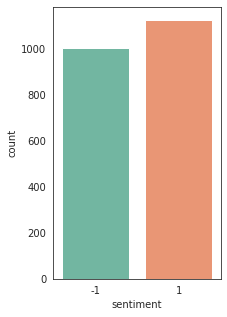

In [0]:
import seaborn as sns
% matplotlib inline
sns.set_style("white")

figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(3, 5)
ax = sns.countplot(data=elecData ,x="sentiment", palette = 'Set2')

In this section we will visualize the most commonly used words or hashtags in the Canadian Election dataset and try to further understand the Eelection data content.

In [0]:
hashtags = []
pattern = re.compile(r"#[a-zA-Z]+")
matches = list(elecData['text'].apply(pattern.findall))

In [0]:
tag_dict = {}
for match in matches:
    for single in match:
        if single not in tag_dict.keys():
            tag_dict[single] = 1
        else:
            tag_dict[single] = tag_dict[single]+1

In [0]:
tag_ordered_list =sorted(tag_dict.items(), key=lambda x:x[1])
tag_ordered_list = tag_ordered_list[::-1]
ordered_values = []
ordered_keys = []
for item in tag_ordered_list[0:50]:
    ordered_keys.append(item[0])
    ordered_values.append(item[1])

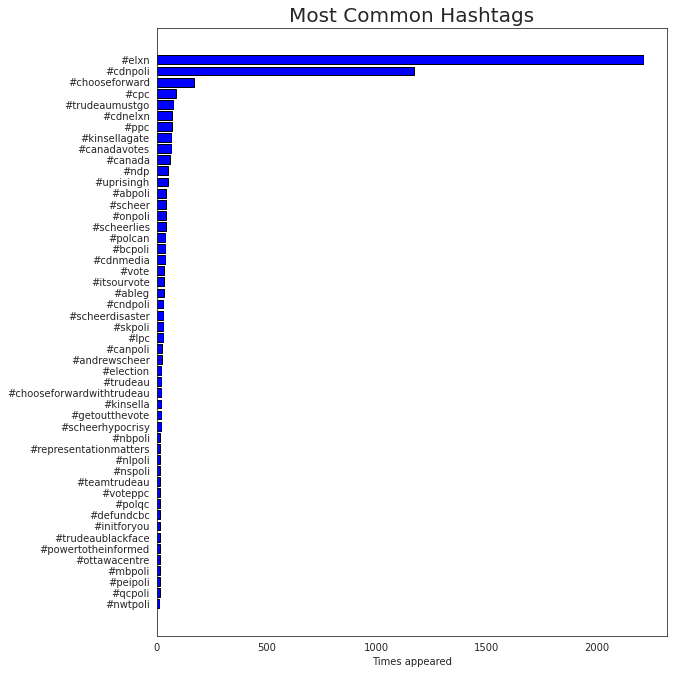

In [0]:
fig, ax = plt.subplots(figsize = (10,10))
y_pos = np.arange(len(ordered_keys))
ax.barh(y_pos ,list(ordered_values)[::-1], align='center', color = 'blue', edgecolor = 'black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(ordered_keys)[::-1])
ax.set_xlabel("Times appeared")
ax.set_title("Most Common Hashtags", fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

In this part we will visualize the most commonly used words in the Generic tweets and Canadian Election dataset and further develop our understanding on the data content.

<function matplotlib.pyplot.show>

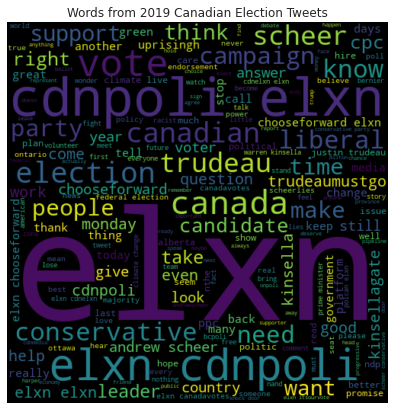

In [0]:
general = ' '.join([i for i in elecData['text']]) 
wordcloud = WordCloud(width=500,height=500,random_state=40,max_font_size=200).generate(general)

plt.figure(figsize=(7,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title('Words from 2019 Canadian Election Tweets')
plt.show

<function matplotlib.pyplot.show>

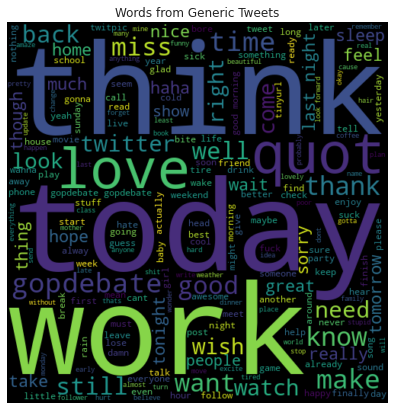

In [0]:
general = ' '.join([i for i in genericData['text']]) 
wordcloud = WordCloud(width=500,height=500,random_state=40,max_font_size=200).generate(general)

plt.figure(figsize=(7,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title('Words from Generic Tweets')
plt.show

### 2.1: Top Canadian Political Parties in 2019 Canadian Federal election¶ 

1. Liberal
  - leader: Justin Trudeau
  - Slogans: "Choose Forward", "Choose Neutral"
  - key words: justin, trudeau, justintrudeau, chooseforward, #chooseforward, chooseneutral, #chooseneutral, liberal

2. Conservative
  - leader: Andrew Scheer
  - Slogans: "It’s time for you to get ahead", "It’s time to roll some heads", "It’s time to rejoin the past", "If you like Doug Ford, you’ll love Andrew Scheer"
  - key words: Andrew, scheer, andrewsheer, ahead, time, roll, rejoin, dougford ,conservative

3. New Democratic Party
  - leader: Jagmeet Singh
  - Slogans: "In it for you"
  - key words: jagmeet, singh, jagmeetsingh,initforyou, #initforyou , newdemocratic, ndp, #ndp

4. Other
- The other ones will be ib the None group

In [0]:
elecData["Liberal"] = elecData['text'].str.contains('justin|trudeau|justintrudeau|chooseforward|#chooseforward|chooseneutral|#chooseneutral|liberal')
elecData["Conservative"] = elecData['text'].str.contains('andrew|scheer|andrewsheer|ahead|time|roll|rejoin|dougford|conservative')
elecData["NewDemocrat"] = elecData['text'].str.contains('jagmeet|singh|jagmeetsingh|#jagmeetsingh|initforyou|#initforyou|newdemocratic|ndp')
elecData["Other"] = 'Other'

In [0]:
elecData.head()

,sentiment,negative_reason,text,Liberal,Conservative,NewDemocrat,Other
0,-1,Women Reproductive right and Racism,instead suggestion agree #canadian #women trus...,False,True,False,Other
1,1,NaN,#allwomanspacewalk real n#etobicokenorth #city...,False,False,False,Other
2,-1,Economy,#brantford cost billion next years justin #elx...,True,False,False,Other
3,1,NaN,#canada #canadaelection #canadavotes n#elxn nc...,False,False,False,Other
4,-1,Economy,#canada #taxpayers sick tire hard earn donate ...,True,False,False,Other


In [0]:
elecData.loc[elecData["Liberal"] == True, "Liberal"] = 'Liberal'
elecData.loc[elecData["Liberal"] == False, "Liberal"] = None

elecData.loc[elecData["Conservative"] == True, "Conservative"] = 'Conservative'
elecData.loc[elecData["Conservative"] == False, "Conservative"] = None

elecData.loc[elecData["NewDemocrat"] == True, "NewDemocrat"] = 'NewDemocrat'
elecData.loc[elecData["NewDemocrat"] == False, "NewDemocrat"] = None

elecData.loc[elecData["Liberal"] == 'Liberal', "Other"] = None
elecData.loc[elecData["Conservative"] == 'Conservative', "Other"] = None
elecData.loc[elecData["NewDemocrat"] == 'NewDemocrat', "Other"] = None

elecData["Party"] = None
elecData.loc[elecData["Liberal"] == 'Liberal', "Party"] = 'Liberal'
elecData.loc[elecData["Conservative"] == 'Conservative', "Party"] = 'Conservative'
elecData.loc[elecData["NewDemocrat"] == 'NewDemocrat', "Party"] = 'NewDemocrat'
elecData.loc[elecData["Other"] == 'Other', "Party"] = 'Other'


# assign separate variable for each political party column
liberal = elecData["Liberal"]
conserv = elecData["Conservative"]
ND = elecData["NewDemocrat"]
other = elecData["Other"]

# Counts for relevant tweets
print(elecData["Liberal"].value_counts())
print(elecData["Conservative"].value_counts())
print(elecData["NewDemocrat"].value_counts())
print(elecData["Other"].value_counts())

Liberal    560
Name: Liberal, dtype: int64
Conservative    587
Name: Conservative, dtype: int64
NewDemocrat    162
Name: NewDemocrat, dtype: int64
Other    1076
Name: Other, dtype: int64


In [0]:
import pandas as pd

classf_tweet_plot = pd.concat([liberal, conserv, ND, other])
classf_tweet_plot.unique()
ctp = pd.DataFrame(classf_tweet_plot, columns = ['Parties'])
ctp_new = ctp[ctp.Parties.notnull()]


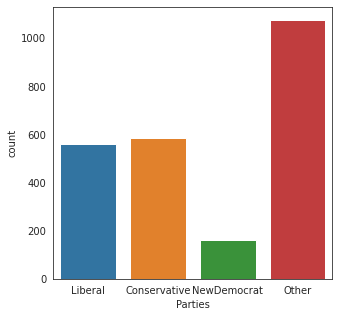

In [0]:
% matplotlib inline
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5, 5)
sns.countplot(data = ctp_new , x = 'Parties')

In what we did above, we first developed a simple method, by deploying the most popular words related to each party, to determine the political party of each tweet. Then we viusalized all the data in terms of their party.
Note that the data related to each party are not necessarily positive, and they be also negative as well. We will discuss the sentiment of them in the following parts.

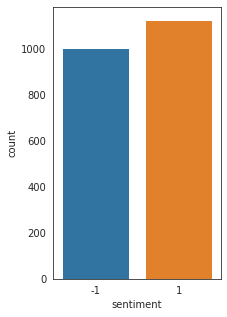

In [0]:
import seaborn as sns
% matplotlib inline
sns.set_style("white")

figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(3, 5)
ax = sns.countplot(data=elecData ,x="sentiment")

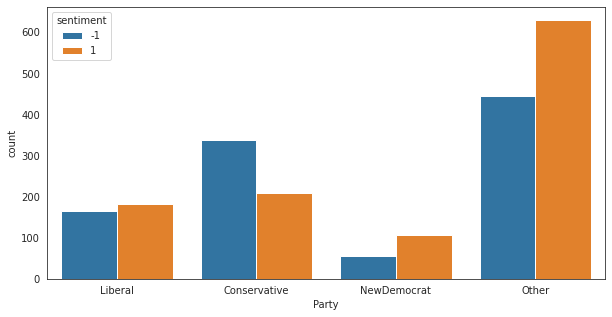

In [0]:
import seaborn as sns
% matplotlib inline
sns.set_style("white")

figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(10, 5)
ax = sns.countplot(data=elecData ,x="Party",hue="sentiment", order=['Liberal','Conservative','NewDemocrat','Other'])

The above figure is a completed version of the figure depicted earlier. In this figure, not only we can see the portion of tweets related to each party, but also we can see the positivity and negativity of each one.


## Part 3: Model Preparation

In this section we split up the generic tweets data randomly into training data (70%) and test data (30%).
Then we will prepare the data for binary classification problem where each tweet is considered a single observation.
In the binary classification model, the outcome variable is the sentiment value, which is 1 as 'Positive', -1 as 'Negative', or 0 as 'Neutral'. The independent variables or features of the model can be whatever you decide.



In [0]:
#----------------------------------------------
# Determining the feature and target value
#----------------------------------------------

X = genericData['text']
Y = genericData['sentiment']

In [0]:
#----------------------------------------------
# Splitting up the data to Test and Train
#----------------------------------------------

from sklearn.model_selection import train_test_split

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y,test_size=0.3, random_state=20)

In [0]:
#----------------------------------------------
# Vectorizing the features 
#----------------------------------------------

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizing using word Count
count_vectorizer = CountVectorizer(lowercase=False)
count_vectorizer.fit(X_Train)
X_Train_countVec = count_vectorizer.transform(X_Train)
X_Test_countVec = count_vectorizer.transform(X_Test)

# Vectorizing using TF-IDF
tfidf_vectorizer = TfidfVectorizer(use_idf=False, norm="l1")
tfidf_vectorizer.fit(X_Train)
X_Train_tfidfVec = tfidf_vectorizer.transform(X_Train)
X_Test_tfidfVec = tfidf_vectorizer.transform(X_Test)

In [0]:
#-------------------------------------------------------
# Looking at Data Strcutures after count vectorization
#-------------------------------------------------------

print(X_Train_countVec.shape)
print(Y_Train.shape)
print(X_Test_countVec.shape)
print(Y_Test.shape)

(93657, 46993)
(93657,)
(40140, 46993)
(40140,)


In [0]:
#-------------------------------------------------------
# Looking at Data Strcutures after TF-IDF vectorization
#-------------------------------------------------------

print(X_Train_tfidfVec.shape)
print(Y_Train.shape)
print(X_Test_tfidfVec.shape)
print(Y_Test.shape)

(93657, 46993)
(93657,)
(40140, 46993)
(40140,)


In [0]:
# We chose TF_IDF method first for further investigations

X_Test_Vec = X_Test_tfidfVec;
X_Train_Vec = X_Train_tfidfVec;

##Part 4: Model Implementation

In this section, we train a multi class classifier model, by employing different methods, on the generic tweets as the training data and apply all different models to Canadian Election 2019 tweets as the test data to obtain an accuracy values. Then compare all different model accuracies.
The following models are implemented and tested in the following parts:
- Logistic Regression
- K-NN 
- Naive Bayes
- SVM 
- Decision Trees
- ensembles (Random Forest, XGBoost)

### 4.1. Training Logistic Regression Model



In [0]:
#-------------------------------------------------------
# Logistic Regression model Leaning and validation
#-------------------------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

model_logReg = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_iter = 1000)
MAE = make_scorer(mean_absolute_error)
folds = 10

MAE_logReg = cross_val_score(model_logReg, X_Train_Vec, Y_Train, cv = folds, scoring=MAE)
print('Logistic regression (multinomial), mean of MAE: ', np.mean(MAE_logReg))
print('Logistic regression (multinomial), variance of MAE: ', np.var(MAE_logReg))

Logistic regression (multinomial), mean of MAE:  0.5579400357462936
Logistic regression (multinomial), variance of MAE:  6.0106106003197726e-05


In [0]:
from sklearn.metrics import classification_report

model_logReg.fit(X_Train_Vec, Y_Train)
predictions = model_logReg.predict(X_Test_Vec)
print(classification_report(Y_Test, predictions))

              precision    recall  f1-score   support

          -1       0.77      0.62      0.69     21361
           0       0.24      0.95      0.39       939
           1       0.69      0.74      0.72     17840

    accuracy                           0.68     40140
   macro avg       0.57      0.77      0.60     40140
weighted avg       0.72      0.68      0.69     40140



### 4.2. Training K-NN


In [0]:
#-------------------------------------------------------
# K-NN model Leaning and validation
#-------------------------------------------------------

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

model_knn = KNeighborsClassifier(n_neighbors = 3)
MAE = make_scorer(mean_absolute_error)
folds = 10

MAE_knn = cross_val_score(model_knn, X_Train_Vec, Y_Train, cv = folds, scoring=MAE)
print('K-NN Model, mean of MAE: ', np.mean(MAE_knn))
print('K-NN Model, variance of MAE: ', np.var(MAE_knn))

K-NN Model, mean of MAE:  0.7542521877418054
K-NN Model, variance of MAE:  8.42191245190686e-05


In [0]:
from sklearn.metrics import classification_report

model_knn.fit(X_Train_Vec, Y_Train)
predictions = model_knn.predict(X_Test_Vec)
print(classification_report(Y_Test, predictions))

              precision    recall  f1-score   support

          -1       0.60      0.85      0.70     21361
           0       0.47      0.22      0.30       939
           1       0.67      0.36      0.47     17840

    accuracy                           0.62     40140
   macro avg       0.58      0.48      0.49     40140
weighted avg       0.63      0.62      0.59     40140



### 4.3. Training Naive Bayes

In [95]:
#-------------------------------------------------------
# Naive Bayes model Leaning and validation
#-------------------------------------------------------

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

model_NB = BernoulliNB()
MAE = make_scorer(mean_absolute_error)
folds = 10

MAE_NB = cross_val_score(model_knn, X_Train_Vec, Y_Train, cv = folds, scoring=MAE)
print('Naive Bayes Model, mean of MAE: ', np.mean(MAE_NB))
print('Naive Bayes Model, variance of MAE: ', np.var(MAE_NB))

Naive Bayes Model, mean of MAE:  0.7542521877418054
Naive Bayes Model, variance of MAE:  8.42191245190686e-05


In [96]:
from sklearn.metrics import classification_report

model_NB.fit(X_Train_Vec, Y_Train)
predictions = model_NB.predict(X_Test_Vec)
print(classification_report(Y_Test, predictions))

              precision    recall  f1-score   support

          -1       0.71      0.80      0.75     21361
           0       0.54      0.01      0.01       939
           1       0.73      0.66      0.69     17840

    accuracy                           0.72     40140
   macro avg       0.66      0.49      0.49     40140
weighted avg       0.71      0.72      0.71     40140



### 4.4. Training SVM


In [97]:
#-------------------------------------------------------
# SVM model Leaning and validation
#-------------------------------------------------------

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

model_SVM = LinearSVC(random_state=0, tol=1e-5)
MAE = make_scorer(mean_absolute_error)
folds = 10

MAE_SVM = cross_val_score(model_SVM, X_Train_Vec, Y_Train, cv = folds, scoring=MAE)
print('SVM Model, mean of MAE: ', np.mean(MAE_SVM))
print('SVM Model, variance of MAE: ', np.var(MAE_SVM))

SVM Model, mean of MAE:  0.5150280923183319
SVM Model, variance of MAE:  5.818218335865419e-05


In [98]:
from sklearn.metrics import classification_report

model_SVM.fit(X_Train_Vec, Y_Train)
predictions = model_SVM.predict(X_Test_Vec)
print(classification_report(Y_Test, predictions))

              precision    recall  f1-score   support

          -1       0.73      0.78      0.75     21361
           0       0.52      0.19      0.27       939
           1       0.72      0.69      0.71     17840

    accuracy                           0.73     40140
   macro avg       0.66      0.55      0.58     40140
weighted avg       0.72      0.73      0.72     40140



### 4.5. Training Decision Tree

In [99]:
#-------------------------------------------------------
# Decision Tree model Leaning and validation
#-------------------------------------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
 
model_tree = DecisionTreeClassifier(random_state=0)
MAE = make_scorer(mean_absolute_error)
folds = 10

MAE_tree = cross_val_score(model_tree, X_Train_Vec, Y_Train, cv = folds, scoring=MAE)
print('Decision Tree Model, mean of MAE: ', np.mean(MAE_tree))
print('Decision Tree Model, variance of MAE: ', np.var(MAE_tree))

Decision Tree Model, mean of MAE:  0.6242777872595029
Decision Tree Model, variance of MAE:  5.704685113521235e-05


In [100]:
from sklearn.metrics import classification_report

model_tree.fit(X_Train_Vec, Y_Train)
predictions = model_tree.predict(X_Test_Vec)
print(classification_report(Y_Test, predictions))

              precision    recall  f1-score   support

          -1       0.70      0.70      0.70     21361
           0       0.41      0.32      0.36       939
           1       0.66      0.66      0.66     17840

    accuracy                           0.67     40140
   macro avg       0.59      0.56      0.57     40140
weighted avg       0.67      0.67      0.67     40140



### 4.6. Training Random Forest

In [101]:
#-------------------------------------------------------
# Random Forest model Leaning and validation
#-------------------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
 
model_RandFor = RandomForestClassifier(max_depth=2, random_state=0)
MAE = make_scorer(mean_absolute_error)
folds = 10

MAE_RandFor = cross_val_score(model_RandFor, X_Train_Vec, Y_Train, cv = folds, scoring=MAE)
print('Random Forest Model, mean of MAE: ', np.mean(MAE_RandFor))
print('Random Forest Model, variance of MAE: ', np.var(MAE_RandFor))

Random Forest Model, mean of MAE:  0.9075135838538116
Random Forest Model, variance of MAE:  6.9109000896686095e-09


In [102]:
from sklearn.metrics import classification_report

model_RandFor.fit(X_Train_Vec, Y_Train)
predictions = model_RandFor.predict(X_Test_Vec)
print(classification_report(Y_Test, predictions))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.53      1.00      0.69     21361
           0       0.00      0.00      0.00       939
           1       0.00      0.00      0.00     17840

    accuracy                           0.53     40140
   macro avg       0.18      0.33      0.23     40140
weighted avg       0.28      0.53      0.37     40140



### 4.7. Training XGBoost

In [103]:
#-------------------------------------------------------
# XGBoost model Leaning and validation
#-------------------------------------------------------

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

model_xgboost = XGBClassifier()
MAE = make_scorer(mean_absolute_error)
folds = 10

MAE_xgboost = cross_val_score(model_xgboost, X_Train_Vec, Y_Train, cv = folds, scoring=MAE)
print('XGBoost Model, mean of MAE: ', np.mean(MAE_xgboost))
print('XGBoost Tree Model, variance of MAE: ', np.var(MAE_xgboost))

XGBoost Model, mean of MAE:  0.6897508829690241
XGBoost Tree Model, variance of MAE:  3.4105583915876886e-05


In [104]:
from sklearn.metrics import classification_report

model_xgboost.fit(X_Train_Vec, Y_Train)
predictions = model_xgboost.predict(X_Test_Vec)
print(classification_report(Y_Test, predictions))

              precision    recall  f1-score   support

          -1       0.61      0.89      0.73     21361
           0       0.55      0.12      0.20       939
           1       0.75      0.36      0.49     17840

    accuracy                           0.64     40140
   macro avg       0.64      0.46      0.47     40140
weighted avg       0.67      0.64      0.61     40140



### 4.8. Testing on Election 2019 
Based on the results of the learning process from the previous part, we choose SVM model as the most accurate one to apply it to Election Data. 

In [0]:
Xp = elecData['text']
Yp = elecData['sentiment']

In [106]:
Xp_Vec = tfidf_vectorizer.transform(Xp)
Xp_Vec.shape

(2133, 46993)

In [107]:
from sklearn.metrics import classification_report

elecPredictions = model_SVM.predict(Xp_Vec)
print(classification_report(Yp, elecPredictions))

              precision    recall  f1-score   support

          -1       0.56      0.74      0.64      1006
           1       0.68      0.49      0.57      1127

    accuracy                           0.61      2133
   macro avg       0.62      0.61      0.60      2133
weighted avg       0.62      0.61      0.60      2133



We can see here that the SVM model has adequate accuracy also when we apply it on Candian Election 2019. In the next parts, we are going to visualize the predicted sentiments for each political party.

In [0]:
#-------------------------------------------------------
# Visualizing the predicted sentiments for each party
#-------------------------------------------------------

predElectData = elecData
predElectData["sentiment"] = elecPredictions

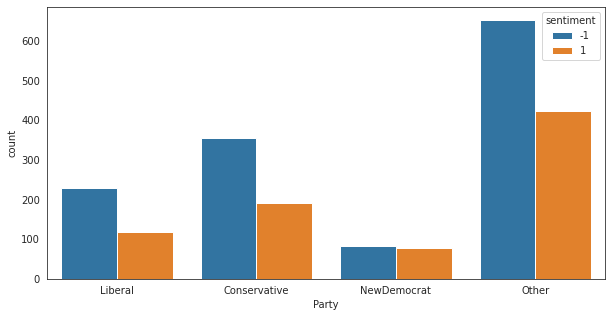

In [113]:
import seaborn as sns
% matplotlib inline
sns.set_style("white")

figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(10, 5)
ax = sns.countplot(data=predElectData ,x="Party",hue="sentiment", order=['Liberal','Conservative','NewDemocrat','Other'])

### 4.9. Negative comments reason learning 
In this part, we Split the negative 2019 Canadian elections tweets into training data (70%) and test data (30%). We use the true sentiment labels in the 2019 Canadian elections data. Having Choosed three algorithms from classification algorithms that performed best (logistic regression, k-NN, SVM), we train multi-class classification models to predict the reason for the negative tweets. There are 10 different negative reasons labelled in the dataset. 

In [0]:
#-------------------------------------------------------
# Selecting features and target values
#-------------------------------------------------------

X = elecData.loc[elecData["sentiment"] == '-1', "text"]
Y = elecData.loc[elecData["sentiment"] == '-1', "negative_reason"]

In [0]:
#-------------------------------------------------------
# Encoding Negative reasons and labelling them
#-------------------------------------------------------

Y = Y.astype('category')
Y = Y.cat.codes

In [0]:
#-------------------------------------------------------
# Splitting and vectorizing the features 
#-------------------------------------------------------

from sklearn.model_selection import train_test_split

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y,test_size=0.3, random_state=20)
vectorizer = TfidfVectorizer(use_idf=False, norm="l1")
vectorizer.fit(X_Train)
X_Train_Vec = vectorizer.transform(X_Train)
X_Test_Vec = vectorizer.transform(X_Test)

In [117]:
print(X_Train_Vec.shape)
print(Y_Train.shape)
print(X_Test_Vec.shape)
print(Y_Test.shape)

(926, 4505)
(926,)
(397, 4505)
(397,)


In [118]:
#-------------------------------------------------------
# Logistic Regression model Leaning and validation
#-------------------------------------------------------

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

model_logReg = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_iter = 1000)
MAE = make_scorer(mean_absolute_error)
folds = 10

MAE_logReg = cross_val_score(model_logReg, X_Train_Vec, Y_Train, cv = folds, scoring=MAE)
print('Logistic regression (multinomial), mean of MAE: ', np.mean(MAE_logReg))
print('Logistic regression (multinomial), variance of MAE: ', np.var(MAE_logReg))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Logistic regression (multinomial), mean of MAE:  2.9095137914913507
Logistic regression (multinomial), variance of MAE:  0.04310949657958428


In [119]:
from sklearn.metrics import classification_report

model_logReg.fit(X_Train_Vec, Y_Train)
predictions = model_logReg.predict(X_Test_Vec)
print(classification_report(Y_Test, predictions))

              precision    recall  f1-score   support

          -1       0.76      0.27      0.40       194
           0       0.15      0.40      0.22        10
           1       0.18      0.38      0.24         8
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       0.25      0.60      0.36        65
           5       0.00      0.00      0.00         2
           6       0.62      0.53      0.57        57
           7       0.07      0.17      0.10         6
           8       0.25      0.20      0.22        40
           9       0.35      0.55      0.43        11

    accuracy                           0.36       397
   macro avg       0.24      0.28      0.23       397
weighted avg       0.54      0.36      0.38       397



In [120]:
#-------------------------------------------------------
# K-NN model Leaning and validation
#-------------------------------------------------------

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

model_knn = KNeighborsClassifier(n_neighbors = 3)
MAE = make_scorer(mean_absolute_error)
folds = 10

MAE_knn = cross_val_score(model_knn, X_Train_Vec, Y_Train, cv = folds, scoring=MAE)
print('K-NN Model, mean of MAE: ', np.mean(MAE_knn))
print('K-NN Model, variance of MAE: ', np.var(MAE_knn))

K-NN Model, mean of MAE:  3.031042543244507
K-NN Model, variance of MAE:  0.06753530298748439


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [121]:
from sklearn.metrics import classification_report

model_knn.fit(X_Train_Vec, Y_Train)
predictions = model_knn.predict(X_Test_Vec)
print(classification_report(Y_Test, predictions))

              precision    recall  f1-score   support

          -1       0.58      0.70      0.63       194
           0       0.17      0.20      0.18        10
           1       0.04      0.12      0.06         8
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       0.20      0.18      0.19        65
           5       0.00      0.00      0.00         2
           6       0.46      0.30      0.36        57
           7       0.00      0.00      0.00         6
           8       0.20      0.07      0.11        40
           9       1.00      0.55      0.71        11

    accuracy                           0.45       397
   macro avg       0.24      0.19      0.20       397
weighted avg       0.43      0.45      0.43       397



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
#-------------------------------------------------------
# SVM model Leaning and validation
#-------------------------------------------------------

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

model_SVM = LinearSVC(random_state=0, tol=1e-5)
MAE = make_scorer(mean_absolute_error)
folds = 10

MAE_SVM = cross_val_score(model_SVM, X_Train_Vec, Y_Train, cv = folds, scoring=MAE)
print('SVM Model, mean of MAE: ', np.mean(MAE_SVM))
print('SVM Model, variance of MAE: ', np.var(MAE_SVM))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


SVM Model, mean of MAE:  3.31091631603553
SVM Model, variance of MAE:  0.027467413761788524


In [123]:
from sklearn.metrics import classification_report

model_SVM.fit(X_Train_Vec, Y_Train)
predictions = model_SVM.predict(X_Test_Vec)
print(classification_report(Y_Test, predictions))

              precision    recall  f1-score   support

          -1       0.52      0.92      0.67       194
           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       0.32      0.14      0.19        65
           5       0.00      0.00      0.00         2
           6       0.80      0.35      0.49        57
           7       0.00      0.00      0.00         6
           8       0.33      0.03      0.05        40
           9       0.00      0.00      0.00        11

    accuracy                           0.53       397
   macro avg       0.18      0.13      0.13       397
weighted avg       0.46      0.53      0.43       397



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Among all of the three models used above, SVM model performed best based on the f1-score. All of the models-including SVM-performance can be improved by hyperparameter tunning.

# Part 3: Results and Discussion